# Interpretation of ResNet neuron activations

This notebook is intended to test some ideas proposed in the paper "Towards Monosemanticity: Decomposing Language Models With Dictionary Learning".
Concretely, learning a sparse autoencoder in order to extract meaningful features from a neural network.
Unlike the original paper, this notebook focuses on a modified ResNet architechture and with a toy problem, i.e., the classification of images containing shapes with the following attributes:

- `shape`: *circle*, *square*, or *triangle*,
- `color`: *red*, *green*, *blue*, or *white*,
- `fill`: *filled* or *empty*,
- `position`: *top-left*, *top-right*, *bottom-left*, or *bottom-right*.

These settings make up 96 different images.
Experimentation can be done using this set of **basic** images or using an **augmented** dataset, being these the two study cases in this notebook.

In [1]:
from math import sqrt
from itertools import product
import os

import torch
from torch import nn
from torch.nn import functional as F
from torchvision.models import resnet18
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid

from dataset import ShapeDataset, COLORS, SHAPES, POSITIONS
from icecream import ic
from matplotlib import pyplot as plt
import numpy as np

In [2]:
STUDY_CASE = 'augmented'
STUDY_CASE = 'basic'

In [3]:
# reproducibility
torch.manual_seed(27)
np.random.seed(27)

## Data

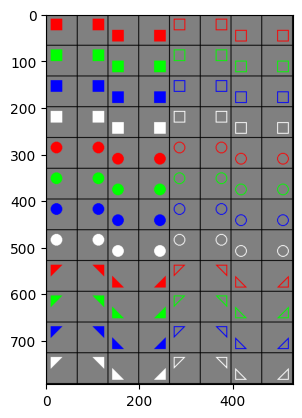

In [4]:
# preview data
dataset = ShapeDataset()
grid = make_grid([dataset[i][0].cpu() for i in range(len(dataset))])
plt.imshow(grid.permute(1, 2, 0))

In [5]:
from torchvision.transforms import Compose, ToTensor, RandomRotation, ColorJitter, GaussianBlur
from torch.utils.data import random_split
from torch.utils.data import DataLoader


if STUDY_CASE == 'basic':
    train_dataset = dataset
    val_dataset = dataset
    test_dataset = dataset
    
elif STUDY_CASE == 'augmented':
    augmentation_transform = Compose([
        RandomRotation(degrees=(-10, 10)),  # small variation for the sake of positions
        ColorJitter(brightness=.3, hue=0.05),
        GaussianBlur(kernel_size=(7, 7), sigma=(0.5, 0.5)),
        ToTensor()
    ])
    dataset = ShapeDataset(augmentation_transform=augmentation_transform)
    train_dataset, val_dataset, test_dataset = random_split(dataset, [0.8 , 0.1, 0.1])
    
print('train images:', len(train_dataset))
print('validation images:', len(val_dataset))
print('test images:', len(test_dataset))

train images: 96
validation images: 96
test images: 96


## Model

In [6]:
# load resnet18 and prune
n_classes = 96
model = resnet18(pretrained=True)
model.layer2 = nn.Identity()
model.layer3 = nn.Identity()
model.layer4 = nn.Identity()
model.fc = nn.Linear(model.layer1[1].conv2.out_channels, n_classes)
model

# freeze all params. but fc
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

model

/home/david/workspaces/pycharm/interpretability/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/david/workspaces/pycharm/interpretability/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Model training

In [7]:
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

config = dict(
    n_epochs=100_000,
    batch_size=8,
    lr=1e-2,
)

In [8]:
train_dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=True)

In [9]:
from contexttimer import Timer

os.makedirs('models', exist_ok=True)
model_path = f'models/model_{STUDY_CASE}.pth'
if os.path.exists(model_path):
    model_weights = torch.load(model_path, weights_only=True)
    model.load_state_dict(model_weights)
    print('Weights loaded.')
else:
    train_losses = []
    val_losses = []
    criterion = CrossEntropyLoss() 
    optimizer = Adam(model.parameters(), lr=config['lr'])
    with Timer() as timer:
      _last_lap = 0
      for epoch in range(config['n_epochs']):
          # train
          model.train()
          _acc_loss = 0
          for step, (x, y) in enumerate(train_dataloader):
              x, y = x.to(device), y.to(device)
              y_pred = model(x)
              loss = criterion(y_pred, y)
              _acc_loss += loss.detach().cpu().numpy()
      
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()
      
              # if step % 10 == 0:
              #     print(f'  {epoch=}, {step=}: loss={loss.detach().numpy():0.2f}')
          train_losses.append(_acc_loss / (step + 1))
          
          # validation
          model.eval()
          with torch.no_grad():
              _acc_loss = 0
              for step, (x, y) in enumerate(val_dataloader):
                  x, y = x.to(device), y.to(device)
                  y_pred = model(x)
                  loss = criterion(y_pred, y)
                  _acc_loss += loss.detach().cpu().numpy()
              val_losses.append(_acc_loss / (step + 1))
      
          # epoch end
          if epoch % 200 == 0:
              _current_lap = timer.elapsed
              print(f'Epoch {epoch}, loss={train_losses[-1]}  val_loss={val_losses[-1]}  elapsed-time={_current_lap - _last_lap}')
              _last_lap = _current_lap

    # save model
    torch.save(model.state_dict(), model_path)

Weights loaded.


In [10]:
try:
    plt.plot(train_losses, label='train', alpha=0.8)
    plt.plot(val_losses, label='val', alpha=0.8)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()
except:
    pass

### Evaluate

Accuracy: 1.0


(<Figure size 640x480 with 1 Axes>, <Axes: ylabel='MulticlassAccuracy'>)

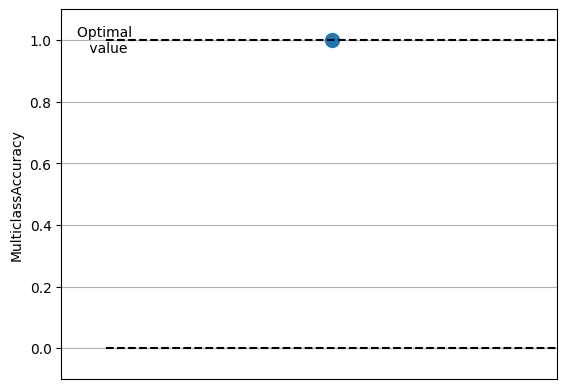

In [11]:
from torchmetrics import Accuracy

model.eval()
accuracy = Accuracy(task='multiclass', num_classes=n_classes, average='micro')
for x, y in test_dataloader:
    y_pred = model(x)
    y_pred = F.softmax(y_pred, dim=-1).argmax(dim=-1)
    acc = accuracy(y, y_pred)
print('Accuracy:', accuracy.compute().numpy())
accuracy.plot()

## Activations inspection

### Prepare inspections

In [12]:
def _plot_tensors_conv_hook(module, input, output, module_name=None):
    input = input[0]

    fig, (ax1, ax2) = plt.subplots(ncols=2)
    _, n_filters, img_size, _ = input.shape
    input_grid = make_grid(input.permute(1, 0, 2, 3), nrow=int(sqrt(n_filters)))  # BxCxWxH
    ax1.imshow(input_grid[0].detach().numpy())
    ax1.set_title(f'input: {n_filters} x ({img_size}, {img_size})')

    _, n_filters, img_size, _ = output.shape
    output_grid = make_grid(output.permute(1, 0, 2, 3), nrow=int(sqrt(n_filters)))  # BxCxWxH
    ax2.imshow(output_grid[0].detach().numpy())
    ax2.set_title(f'output: {n_filters} x ({img_size}, {img_size})')

    if module_name is None:
        plt.suptitle(str(module).split('(')[0])
    else:
        module_type = str(module).split('(')[0]
        plt.suptitle(f'{module_name} ({module_type})')
    plt.tight_layout()
    plt.show()

def _plot_tensors_mlp_hook(module, input, output, module_name=None):
    input = input[0]
    n_inputs = input.shape[1]
    n_outputs = output.shape[1]
    
    fig, (ax1, ax2) = plt.subplots(nrows=2)
    ax1.imshow(input.detach().numpy())
    ax1.set_title(f'input: {n_inputs}')
    ax1.set_yticks([], [])
    
    ax2.imshow(output.detach().numpy())
    ax2.set_title(f'output: {n_outputs}')
    ax2.set_yticks([], [])

    if module_name is None:
        plt.suptitle(str(module).split('(')[0])
    else:
        module_type = str(module).split('(')[0]
        plt.suptitle(f'{module_name} ({module_type})')
    plt.tight_layout()
    plt.show()


def _plot_predictions(y, y_pred):
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3)
    ax1.imshow(y_pred.detach().numpy())
    ax1.set_title(f'y_pred (logits)')
    ax1.set_yticks([], [])

    pred_class = torch.argmax(F.softmax(y_pred, dim=-1), dim=-1)
    ax2.imshow(torch.eye(n_classes)[pred_class].detach().numpy())
    ax2.set_title(f'y_pred (argmax)')
    ax2.set_yticks([], [])

    ax3.imshow(y.detach().numpy())
    ax3.set_title(f'y')
    ax3.set_yticks([], [])

    plt.suptitle(f'Predictions')
    plt.tight_layout()
    plt.show()

def remove_all_hooks():
    model.layer1[0]._forward_hooks = OrderedDict()
    model.layer1[1]._forward_hooks = OrderedDict()
    model.avgpool._forward_hooks = OrderedDict()
    model.fc._forward_hooks = OrderedDict()

In [13]:
from collections import OrderedDict
from functools import partial

remove_all_hooks()
model.layer1[0].register_forward_hook(partial(_plot_tensors_conv_hook, module_name='layer1[0]'))
model.layer1[1].register_forward_hook(partial(_plot_tensors_conv_hook, module_name='layer1[1]'))
model.avgpool.register_forward_hook(partial(_plot_tensors_conv_hook, module_name='avgpool'))
model.fc.register_forward_hook(partial(_plot_tensors_mlp_hook, module_name='fc'))

### Inspect activations

shape: {'shape': 'square', 'color': 'red', 'fill': True, 'position': 'top-right'}


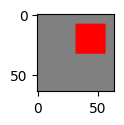

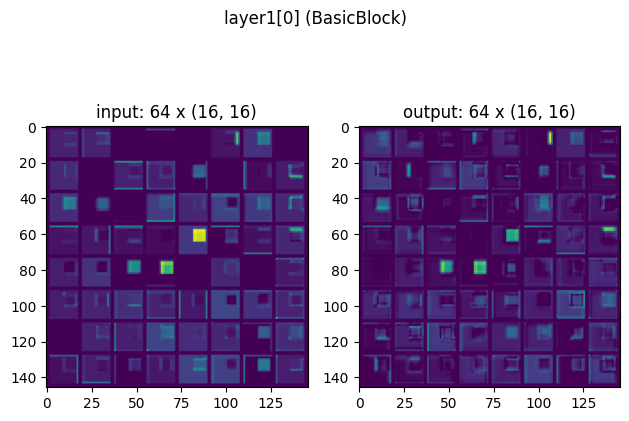

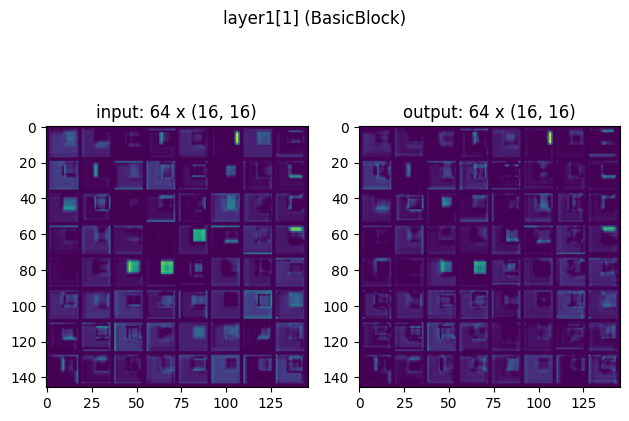

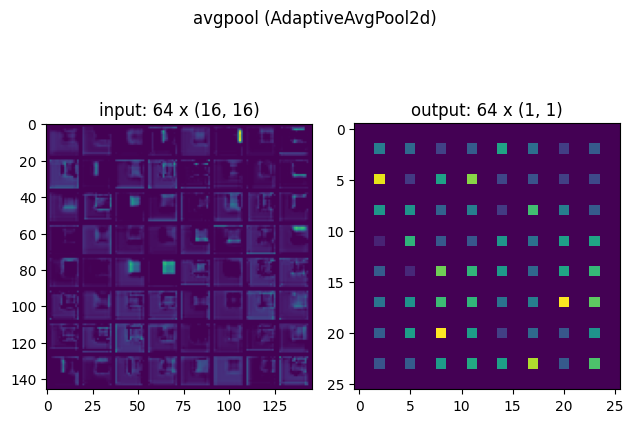

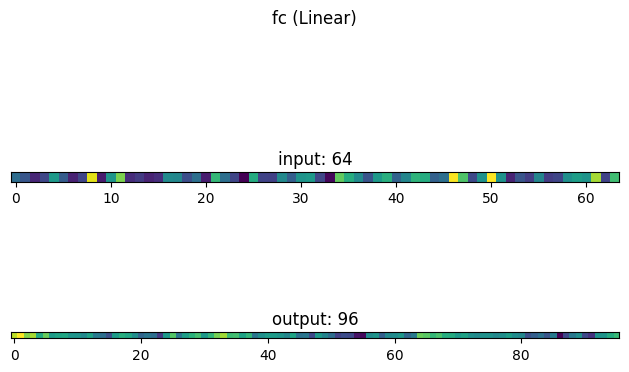

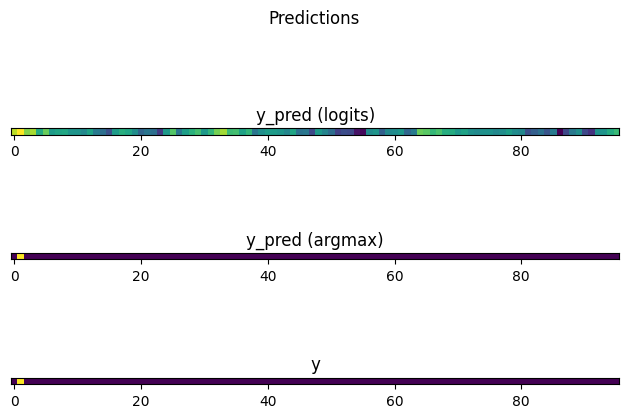

target:     {'shape': 'square', 'color': 'red', 'fill': True, 'position': 'top-right'}
prediction: {'shape': 'square', 'color': 'red', 'fill': True, 'position': 'top-right'}


In [14]:
x, y = train_dataset[1]

plt.figure(figsize = (1, 1))
plt.imshow(x.permute(1, 2, 0))
print('shape:', dataset.targets_info[torch.argmax(y, dim=-1)])

y_pred = model(x.unsqueeze(0))
_plot_predictions(y.unsqueeze(0), y_pred)

print('target:    ', dataset.targets_info[torch.argmax(y, dim=-1)])
print('prediction:', dataset.targets_info[torch.argmax(F.softmax(y_pred, dim=-1), dim=-1)])

## Autoencoder

Sparse autoencoder as defined in "Towards Monosemanticity"

Encoder:

$
\begin{align*}
    \bar{\textbf{x}} &= \textbf{x} - \textbf{b}_d \\
    \textbf{f} &= \text{ReLU}(W_e \bar{\textbf{x}} + \textbf{b}_e) \\
    \end{align*}
$

Decoder:

$
\begin{align*}
    \hat{\textbf{x}} &= W_d \textbf{f} + \textbf{b}_d \\
\end{align*}
$

In [15]:
# module to inspect
module = model.avgpool
n_activations = 64

In [16]:
ae_config = {
    'n_epochs': 10_000,
    'lambda': 3e-3,
    'lr': 1e-3,
    'n_features': n_activations * 2
}

In [17]:
from autoencoder import Autoencoder

# autoencoder
n_features = ae_config['n_features']
ae = Autoencoder(n_activations, n_features)
ae

Autoencoder(
  (encoder): _Encoder(
    (W_e): Linear(in_features=64, out_features=128, bias=False)
  )
  (decoder): _Decoder(
    (W_d): Linear(in_features=128, out_features=64, bias=False)
  )
)

In [18]:
# prepare model for inspection
model.eval()
activations = None
def _module_hook(module, input, output):
    activations.append(output)

remove_all_hooks()
module.register_forward_hook(_module_hook)

## Autoencoder training

Training is performed minimizing the loss function:

$\mathcal{L} = \frac{1}{|X|} \sum_{\textbf{x} \in X} \|\textbf{x} - \hat{\textbf{x}}\|_2^2 + \lambda \|\textbf{f}\|_1$,

this is the sum of the $L_2$ norm of the reconstruction error of the neuron activations plus the $L_1$ norm of the activations of the learned features weighted by $\lambda$.

In [19]:
from torch.linalg import vector_norm

ae_path = f'models/ae_{STUDY_CASE}.pth'
if os.path.exists(ae_path):
    ae_weights = torch.load(ae_path, weights_only=True)
    ae.load_state_dict(ae_weights)
    print('Weights loaded.')
else:
    losses = []
    l2_losses = []
    l1_losses = []
    optimizer = Adam(ae.parameters(), lr=ae_config['lr'])
    ae.train()
    for epoch in range(ae_config['n_epochs']):
        for x, y in train_dataloader:
            
            # get activations
            activations = []
            y_pred = model(x)
            _a = activations
            batch_size = x.shape[0]
            activations = torch.cat(activations, dim=1).reshape(batch_size, -1)
    
            # AE forward pass
            ae.zero_grad()
            activations_pred, features = ae.forward(activations)
            l1 = vector_norm(features, ord=1)
            l2 = torch.mean(vector_norm(activations - activations_pred, ord=2, dim=1))  
            loss = l2 + ae_config['lambda'] * l1
            losses.append(loss.detach().numpy())
            l1_losses.append(l1.detach().numpy() * ae_config['lambda'])
            l2_losses.append(l2.detach().numpy())
            
            # AE backward pass
            loss.backward()
            optimizer.step()
    
        if epoch % 1000 == 0:
            print(f'Epoch {epoch}, loss={losses[-1]} l1={l1_losses[-1]} l2={l2_losses[-1]}')

    # save weights
    torch.save(ae.state_dict(), ae_path)

Weights loaded.


In [20]:
try:
    plt.plot(losses, label='loss')
    plt.plot(l1_losses, label='l1 (scaled)')
    plt.plot(l2_losses, label='l2')
    plt.legend()
    plt.yscale('log')
except:
    pass

## Analyze autoencoder

In [21]:
@torch.no_grad()
def analyze(model, ae, image):
    global activations
    activations = []
    
    y_pred = model(image.unsqueeze(0))
    activations = torch.cat(activations, dim=1).reshape(-1)
    features = ae.encoder(activations)
    
    return dict(
        neuron_act=activations.detach().numpy(),
        feature_act=features.detach().numpy(),
        logits=y_pred.squeeze(0).detach().numpy()
    ) 

In [22]:
ae.eval()
model.eval()
run_name = f'test/{n_features}'
results = []
for idx, (x, y) in enumerate(dataset):
    _results = dict(run_name=run_name, image_idx=idx, x=x.detach().numpy(), y=y.detach().numpy())
    _results.update(dataset.targets_info[torch.argmax(y, dim=-1)])
    _results.update(analyze(model, ae, x))
    results.append(_results)

In [23]:
import pandas as pd

results_df = pd.DataFrame(results)
results_df.head()

,run_name,image_idx,x,y,shape,color,fill,position,neuron_act,feature_act,logits
0,test/128,0,"[[[0.5019608, 0.5019608, 0.5019608, 0.5019608,...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",square,red,True,top-left,"[0.44212502, 0.36324835, 0.22212258, 0.3024589...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.039154675, 0.0, 0....","[-65.88045, -75.92429, -76.84461, -90.99976, -..."
1,test/128,1,"[[[0.5019608, 0.5019608, 0.5019608, 0.5019608,...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",square,red,True,top-right,"[0.43992397, 0.3553532, 0.20587698, 0.3026212,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.034347948, 0.0, 0....","[-76.49252, -67.88739, -83.421196, -78.77025, ..."
2,test/128,2,"[[[0.5019608, 0.5019608, 0.5019608, 0.5019608,...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",square,red,True,bottom-left,"[0.41983947, 0.32548237, 0.20137256, 0.3068769...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.03706168, 0.0, 0.0...","[-78.0327, -84.50856, -67.881645, -79.16235, -..."
3,test/128,3,"[[[0.5019608, 0.5019608, 0.5019608, 0.5019608,...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",square,red,True,bottom-right,"[0.41870534, 0.3180954, 0.18549155, 0.30937397...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0316613, 0.0, 0.0,...","[-87.2791, -76.25603, -75.965355, -67.56005, -..."
4,test/128,4,"[[[0.5019608, 0.5019608, 0.5019608, 0.5019608,...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",square,red,False,top-left,"[0.41984507, 0.38024005, 0.22624658, 0.2039397...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.01567474, 0.0, 0.0...","[-79.13386, -87.01228, -93.20338, -106.76544, ..."


In [24]:
import numpy as np

def filter(df, column, value):
    return df[df[column] == value]

def neuron_act(df):
    return np.stack(df.neuron_act)
    
def feature_act(df):
    return np.stack(df.feature_act)

def logits(df):
    return np.stack(df.neuron_act)


Text(0, 0.5, 'image')

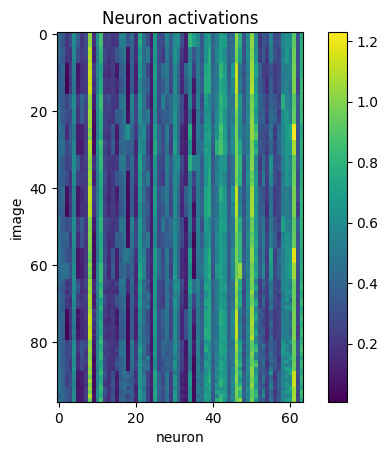

In [25]:
plt.imshow(neuron_act(results_df))
plt.colorbar()
plt.title('Neuron activations')
plt.xlabel('neuron')
plt.ylabel('image')

Text(0, 0.5, 'image')

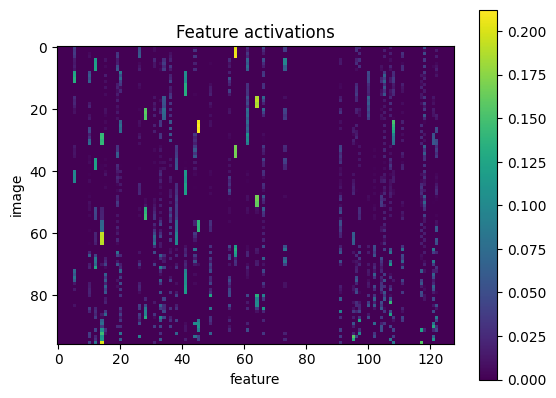

In [26]:
plt.imshow(feature_act(results_df))
plt.colorbar()
plt.title('Feature activations')
plt.xlabel('feature')
plt.ylabel('image')

Text(0, 0.5, 'image')

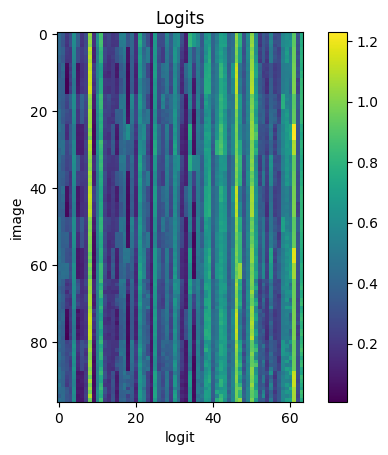

In [27]:
plt.imshow(logits(results_df))
plt.colorbar()
plt.title('Logits')
plt.xlabel('logit')
plt.ylabel('image')

### Feature analysis

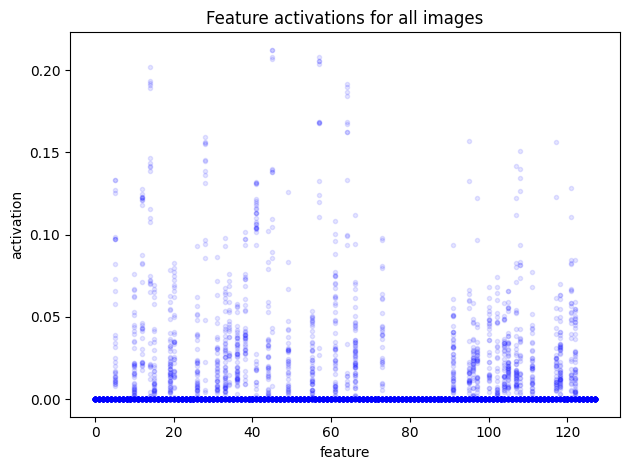

In [28]:
plt.plot(feature_act(results_df).T, '.', alpha=0.1, color='blue', linewidth=1)
plt.title(f'Feature activations for all images')
plt.xlabel('feature')
plt.ylabel('activation')
plt.tight_layout()
plt.show()

In [29]:
# active vs. non-active features
n_feature_activations = feature_act(results_df).sum(0)
_n_active = np.count_nonzero(n_feature_activations)
relevant_features = np.arange(ae_config['n_features'])[n_feature_activations != 0]
print('active features:', _n_active)
print('non-active features:', ae_config['n_features'] - _n_active)
print('relevant features:', relevant_features)

active features: 39
non-active features: 89
relevant features: [  5  10  12  14  15  19  20  26  28  31  33  34  36  38  41  44  45  49
  55  57  61  64  66  73  91  95  96  97 100 102 104 105 107 108 111 117
 118 121 122]


#### UMAP
UMAP projection of features based on shape, color, fill, and position.

In [30]:
import umap

_features = feature_act(results_df)

reducer = umap.UMAP()
embedding = reducer.fit_transform(_features)
embedding.shape

/home/david/workspaces/pycharm/interpretability/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(96, 2)

Text(0.5, 1.0, 'UMAP projection (shape, color, fill)')

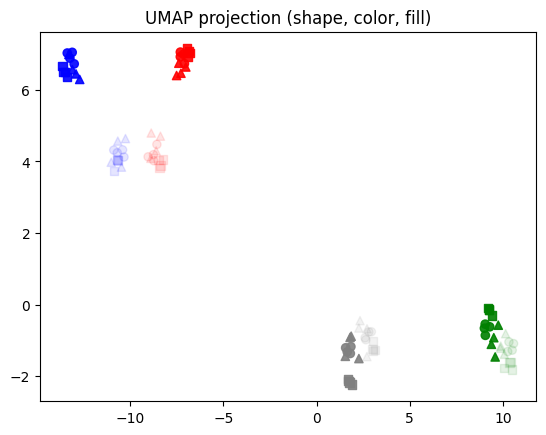

In [31]:
for shape in SHAPES:
    _slice = results_df['shape'] == shape
    plt.scatter(
        embedding[_slice, 0],
        embedding[_slice, 1],
        c=[('gray' if _c == 'white' else _c) for _c in results_df.color[_slice]],
        alpha=[(0.9 if _f else 0.1) for _f in results_df.fill[_slice]],
        marker={'triangle': '^', 'square': 's', 'circle': 'o'}[shape]
    )
plt.title('UMAP projection (shape, color, fill)')

Text(0.5, 1.0, 'UMAP projection (positions)')

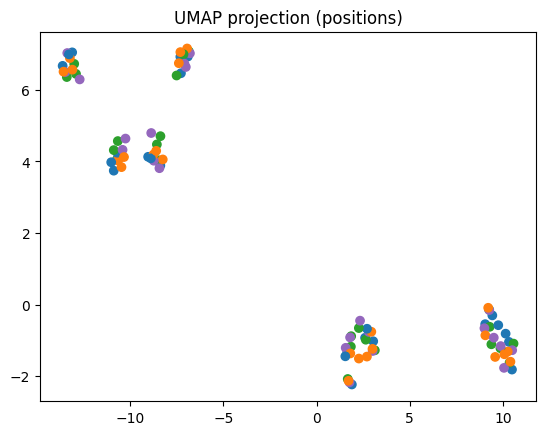

In [32]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[{'top-left': 'tab:blue', 'top-right': 'tab:green', 'bottom-right': 'tab:orange', 'bottom-left': 'tab:purple'}[_p] for _p in results_df.position],
)
plt.title('UMAP projection (positions)')

Text(0.5, 1.0, 'UMAP projection (shape)')

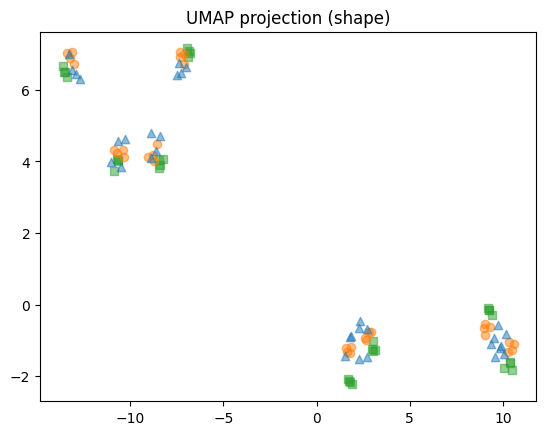

In [33]:
for shape in SHAPES:
    _slice = results_df['shape'] == shape
    plt.scatter(
        embedding[_slice, 0],
        embedding[_slice, 1],
        c={'triangle': 'tab:blue', 'square': 'tab:green', 'circle': 'tab:orange'}[shape],
        marker={'triangle': '^', 'square': 's', 'circle': 'o'}[shape],
        alpha=0.5
    )
plt.title('UMAP projection (shape)')

#### Feature activation per image attribute

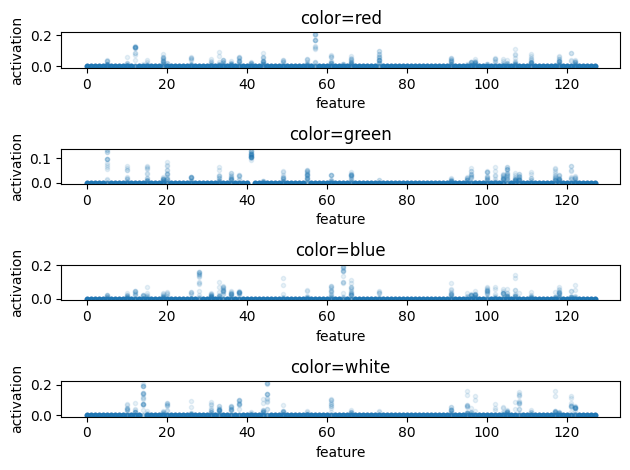

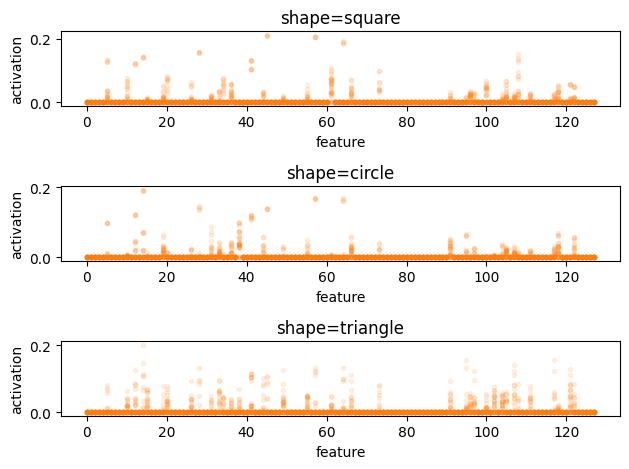

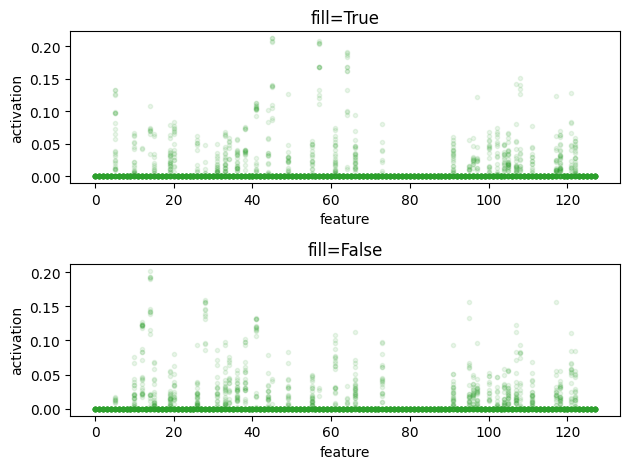

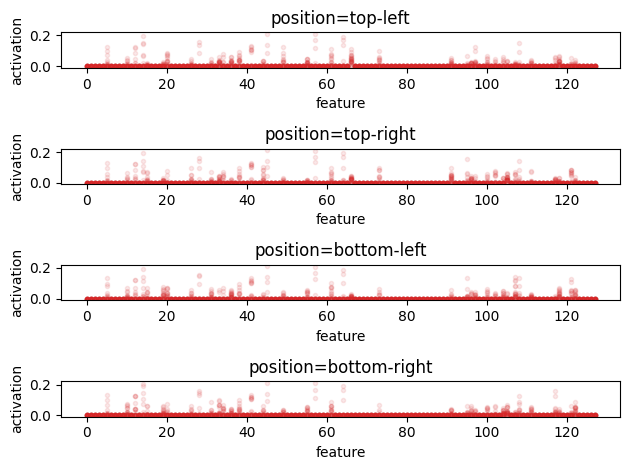

In [34]:
def plot_feature_activations(image_feature, attribute_values, color='blue'):
    fig, axes = plt.subplots(nrows=len(attribute_values))
    for idx, attribute_value in enumerate(attribute_values):
        _df = filter(results_df, image_feature, attribute_value)
        axes[idx].plot(feature_act(_df).T, '.', alpha=0.1, color=color, linewidth=1)
        axes[idx].set_title(f'{image_feature}={attribute_value}')

        axes[idx].set_xlabel('feature')
        axes[idx].set_ylabel('activation')
    plt.tight_layout()
    plt.show()

plot_feature_activations('color', COLORS, color='tab:blue')
plot_feature_activations('shape', SHAPES, color='tab:orange')
plot_feature_activations('fill', [True, False], color='tab:green')
plot_feature_activations('position', POSITIONS, color='tab:red')

#### Feature metrics per image attribute

Compute feature metrics for sets of images with a given attribute.

Metrics:
 - `act_count`: number of times the feature was activated,
 - `act_total`: sum of the feature activation levels,
 - `act_precision`: precision of the feature,
 - `act_recall`: recall (sensitivity) of the feature.

In [35]:
from torchmetrics.classification import BinaryPrecision, BinaryRecall

# compute feature metrics
image_attributes = list(product(['color'], COLORS)) + list(product(['shape'], SHAPES)) + list(product(['fill'], [True, False])) + list(product(['position'], POSITIONS)) 

metrics = []
for image_attribute, attribute_value in image_attributes:
    for feature_id in relevant_features:
        # get feature activations
        _feature_act = feature_act(results_df)[:, feature_id]
        _feature_act_filtered = feature_act(filter(results_df, image_attribute, attribute_value))[:, feature_id]
        
        _expected_non_zero_act = torch.tensor(results_df[image_attribute] == attribute_value)
        _non_zero_act = torch.tensor(_feature_act != 0)

        metrics.append(dict(
            feature_id=feature_id,
            image_attribute=image_attribute,
            attribute_value=attribute_value,
            image_type=f'{image_attribute}={attribute_value}',
            act_count=np.count_nonzero(_feature_act_filtered),
            act_total=np.sum(_feature_act_filtered),
            act_precision=BinaryPrecision()(_non_zero_act, _expected_non_zero_act).numpy(),
            act_recall=BinaryRecall()(_non_zero_act, _expected_non_zero_act).numpy()
        ))

metrics = pd.DataFrame(metrics)
metrics

,feature_id,image_attribute,attribute_value,image_type,act_count,act_total,act_precision,act_recall
0,5,color,red,color=red,12,0.244211,0.36363637,0.5
1,10,color,red,color=red,10,0.151566,0.22222222,0.41666666
2,12,color,red,color=red,13,1.385360,0.44827586,0.5416667
3,14,color,red,color=red,4,0.015859,0.13333334,0.16666667
4,15,color,red,color=red,8,0.113471,0.23529412,0.33333334
...,...,...,...,...,...,...,...,...
502,111,position,bottom-right,position=bottom-right,12,0.322995,0.29268292,0.5
503,117,position,bottom-right,position=bottom-right,14,0.520379,0.3783784,0.5833333
504,118,position,bottom-right,position=bottom-right,7,0.146794,0.13207547,0.29166666
505,121,position,bottom-right,position=bottom-right,5,0.124855,0.15151516,0.20833333


#### Individual feature analysis: color=blue

In [36]:
image_attribute = 'color'
attribute_value = 'blue'
print(f'Selected attribute: {image_attribute}={attribute_value}')

(filter(metrics, 'image_type', f'{image_attribute}={attribute_value}')
 .sort_values(by=['act_recall'], ascending=False)
 .style
 .background_gradient(subset=['act_count', 'act_total'], cmap='coolwarm')
 .background_gradient(subset=['act_precision', 'act_recall'], cmap='coolwarm', vmin=0, vmax=1)
)

Selected attribute: color=blue


,feature_id,image_attribute,attribute_value,image_type,act_count,act_total,act_precision,act_recall
86,28,color,blue,color=blue,17,1.692953,1.0,0.7083333
100,66,color,blue,color=blue,16,0.764024,0.28070176,0.6666667
114,118,color,blue,color=blue,16,0.501460,0.3018868,0.6666667
99,64,color,blue,color=blue,16,1.896198,0.8,0.6666667
106,100,color,blue,color=blue,15,0.598527,0.48387095,0.625
98,61,color,blue,color=blue,15,0.571162,0.29411766,0.625
87,31,color,blue,color=blue,15,0.255976,0.4054054,0.625
110,107,color,blue,color=blue,13,0.519590,0.29545453,0.5416667
102,91,color,blue,color=blue,13,0.444726,0.26530612,0.5416667
89,34,color,blue,color=blue,13,0.681301,0.5652174,0.5416667


In [37]:
feature_id = 28  # feature with best recall for color=blue in 'basic' problem

(filter(metrics, 'feature_id', feature_id)
 .sort_values(by=['act_precision'], ascending=False)
 .style
 .background_gradient(subset=['act_count', 'act_total'], cmap='coolwarm')
 .background_gradient(subset=['act_precision', 'act_recall'], cmap='coolwarm', vmin=0, vmax=1)
)

,feature_id,image_attribute,attribute_value,image_type,act_count,act_total,act_precision,act_recall
86,28,color,blue,color=blue,17,1.692953,1.0,0.7083333
320,28,fill,False,fill=False,12,1.600752,0.7058824,0.25
203,28,shape,circle,shape=circle,7,0.586732,0.4117647,0.21875
242,28,shape,triangle,shape=triangle,6,0.479269,0.3529412,0.1875
281,28,fill,True,fill=True,5,0.092201,0.29411766,0.104166664
398,28,position,top-right,position=top-right,5,0.423385,0.29411766,0.20833333
476,28,position,bottom-right,position=bottom-right,5,0.492354,0.29411766,0.20833333
164,28,shape,square,shape=square,4,0.626952,0.23529412,0.125
437,28,position,bottom-left,position=bottom-left,4,0.398631,0.23529412,0.16666667
359,28,position,top-left,position=top-left,3,0.378583,0.1764706,0.125


#### Individual feature analysis: position=top-right

In [38]:
image_attribute = 'position'
attribute_value = 'top-right'
print(f'Selected attribute: {image_attribute}={attribute_value}')

(filter(metrics, 'image_type', f'{image_attribute}={attribute_value}')
 .sort_values(by=['act_recall'], ascending=False)
 .style
 .background_gradient(subset=['act_count', 'act_total'], cmap='coolwarm')
 .background_gradient(subset=['act_precision', 'act_recall'], cmap='coolwarm', vmin=0, vmax=1)
)

Selected attribute: position=top-right


,feature_id,image_attribute,attribute_value,image_type,act_count,act_total,act_precision,act_recall
421,105,position,top-right,position=top-right,21,0.579191,0.4375,0.875
414,91,position,top-right,position=top-right,18,0.626060,0.36734694,0.75
412,66,position,top-right,position=top-right,18,0.453399,0.31578946,0.75
400,33,position,top-right,position=top-right,15,0.285447,0.3125,0.625
405,44,position,top-right,position=top-right,15,0.517744,0.42857143,0.625
410,61,position,top-right,position=top-right,14,0.427475,0.27450982,0.5833333
416,96,position,top-right,position=top-right,11,0.250925,0.31428573,0.45833334
427,121,position,top-right,position=top-right,11,0.618202,0.33333334,0.45833334
425,117,position,top-right,position=top-right,11,0.187390,0.2972973,0.45833334
408,55,position,top-right,position=top-right,11,0.084971,0.2244898,0.45833334


In [39]:
feature_id = 105  # feature with best recall for position=top-right in 'basic' problem

(filter(metrics, 'feature_id', feature_id)
 .sort_values(by=['act_precision'], ascending=False)
 .style
 .background_gradient(subset=['act_count', 'act_total'], cmap='coolwarm')
 .background_gradient(subset=['act_precision', 'act_recall'], cmap='coolwarm', vmin=0, vmax=1)
)

,feature_id,image_attribute,attribute_value,image_type,act_count,act_total,act_precision,act_recall
304,105,fill,True,fill=True,26,0.733066,0.5416667,0.5416667
343,105,fill,False,fill=False,22,0.514524,0.45833334,0.45833334
421,105,position,top-right,position=top-right,21,0.579191,0.4375,0.875
226,105,shape,circle,shape=circle,20,0.330306,0.41666666,0.625
70,105,color,green,color=green,18,0.639214,0.375,0.75
187,105,shape,square,shape=square,18,0.531408,0.375,0.5625
499,105,position,bottom-right,position=bottom-right,17,0.463845,0.35416666,0.7083333
109,105,color,blue,color=blue,12,0.263939,0.25,0.5
148,105,color,white,color=white,11,0.216619,0.22916667,0.45833334
265,105,shape,triangle,shape=triangle,10,0.385876,0.20833333,0.3125
